In [8]:
from glob import glob
import os

from dask.distributed import LocalCluster
import pandas as pd
import pyarrow.dataset as pads
import pyarrow.csv as pcsv
import pyarrow.compute as pc

import numpy as np

In [2]:
each_game = glob('../data/2024_SMT_Data_Challenge/game_info/**/*.csv', recursive=True)

In [3]:
each_game = [game.replace('game_info', '{}', 2)for game in each_game]

In [4]:
def get_data_from_game(game_path, table_type, columns, filter=None):
    game_events_path = game_path.replace("{}", table_type, 2)
    game_events_table = pcsv.read_csv(game_events_path, convert_options=pcsv.ConvertOptions(
        include_columns=columns
    ))
    if filter is not None:
        game_events_table.filter(filter)
    return game_events_table.to_pandas()

In [5]:
test = get_data_from_game(each_game[0], "game_events", ['game_str', 'timestamp', 'play_per_game', 'event_code'], pc.field('event_code')==1)

In [6]:
def handle_game(game_path):
    pitches = get_data_from_game(
        game_path,
        "game_events",
        ['game_str', 'timestamp', 'play_per_game', 'event_code'],
        pc.field('event_code')==1
    )
    pitch_info_list = []
    for _, pitch in pitches.iterrows():
        pitch_info_list.append(
            handle_pitch(game_path, pitch)
        )
    return pitch_info_list

In [7]:
def handle_pitch(game_path, pitch):
    pitcher_position_code = 1
    ball_pos_df = get_data_from_game(
        game_path,
        "ball_pos",
        ['ball_position_x', 'ball_position_y', 'ball_position_z', 'timestamp'],
        pc.field("timestamp")==pitch.timestamp
    )
    player_pos_df = get_data_from_game(
        game_path,
        "player_pos",
        ['field_x', 'field_y', 'timestamp', 'player_position'],
        ((pc.field("timestamp")==pitch.timestamp) & (pc.field("player_position")==pitcher_position_code))
    )
    game_info_df = get_data_from_game(
        game_path,
        "game_info",
        ['play_per_game', 'pitcher'],
        pc.field('play_per_game')==pitch.play_per_game
    )
    return {
        "game_str": pitch.game_str,
        "timestamp": pitch.timestamp,
        "play_per_game": pitch.play_per_game,
        "x_ball_pos": ball_pos_df.iloc[0].ball_position_x,
        "y_ball_pos": ball_pos_df.iloc[0].ball_position_y,
        "z_ball_pos": ball_pos_df.iloc[0].ball_position_z,
        "x_pitcher_pos": player_pos_df.iloc[0].field_x,
        "y_pitcher_pos": player_pos_df.iloc[0].field_y,
        "pitcher_player_id": game_info_df.iloc[0].pitcher
    }

In [12]:
from tqdm.notebook import tqdm
all_pitches = []
for game in tqdm(each_game):
    all_pitches.append(handle_game(game))

  0%|          | 0/338 [00:00<?, ?it/s]

In [17]:
df = pd.DataFrame(all_pitches)

In [19]:
df.to_csv('pitcher-location.csv', index=False)

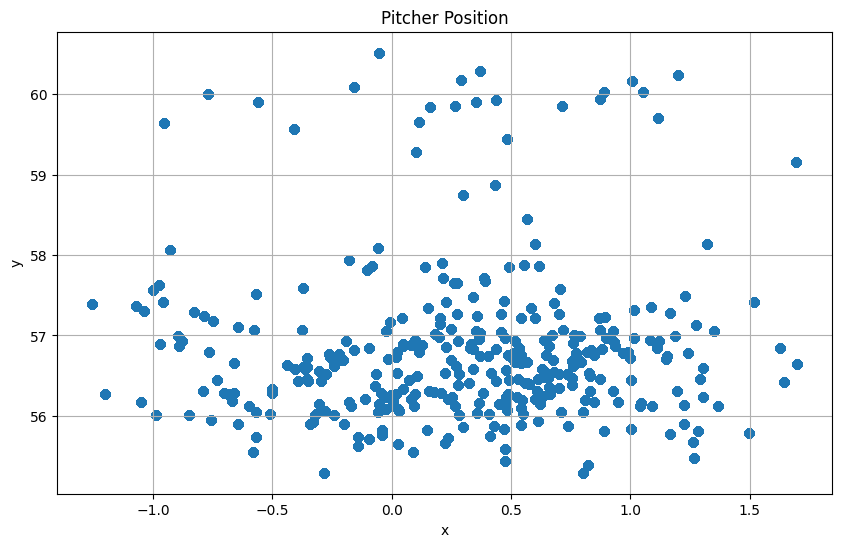

In [46]:
import matplotlib.pyplot as plt

filter = df['y_pitcher_pos'] > 50

plt.figure(figsize=(10, 6))
plt.scatter(df.loc[filter]['x_pitcher_pos'], df.loc[filter]['y_pitcher_pos'], marker='o')
# plt.scatter(df['x_pitcher_pos'], df['y_pitcher_pos'], marker='o')
plt.title('Pitcher Position')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [6]:
df = pd.read_csv("./pitcher-location.csv")

/var/folders/d6/gm7k3q6n1xs1k8nybphryd_80000gn/T/ipykernel_20239/4113213628.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./pitcher-location.csv")


In [9]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

filter_dropdown = widgets.Dropdown(
    options=df.pitcher_player_id.replace('\\N', np.nan).dropna().unique(),
    description='Filter:'
)

# Define the plotting function
def plot_data(filter_val):
    filtered_df = df[df['pitcher_player_id'] == filter_val]
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_df['x_pitcher_pos'], filtered_df['y_pitcher_pos'], marker='.')
    plt.scatter(filtered_df['x_ball_pos'], filtered_df['y_ball_pos'], marker='.')
    plt.title(f'Plot of pitching location (Filtered by {filter_val})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

# Link the widgets to the plotting function
interactive_plot = widgets.interactive(plot_data, filter_val=filter_dropdown)

# display(filter_dropdown)
interactive_plot

interactive(children=(Dropdown(description='Filter:', options=(768.0, 645.0, 893.0, 972.0, 966.0, 389.0, 642.0…

In [55]:

df.pitcher_player_id.replace('\\N', np.nan).dropna().unique()

/var/folders/d6/gm7k3q6n1xs1k8nybphryd_80000gn/T/ipykernel_68651/1074141267.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.pitcher_player_id.replace('\\N', np.nan).dropna().unique()


array([ 768.,  645.,  893.,  972.,  966.,  389.,  642.,  675.,  463.,
        760.,  420.,  983.,  356.,  995.,  924.,  683.,  602.,  858.,
        961.,  606.,  551.,  437.,  305.,  550.,  308.,  549.,  322.,
        456.,  808.,  674.,  433.,  849., 7340.,  436.,  891.,  949.,
        677.,  843.,  612.,  318.,  933.,  722.,  484.,  956.,  659.,
        873.,  987., 3764.,  523.,  364.,  354.,  814.,  402., 5991.,
       6913.,  639.,  465.,  564.,  741.,  733.,  473.,  655.,  913.,
        819.,  673.,  859.])

In [52]:
df.pitcher_player_id.drop_duplicates()

0         768.0
865       645.0
2251      893.0
4534      972.0
5873      966.0
          ...  
347087      NaN
347088      NaN
347089      NaN
347090      NaN
347091      NaN
Name: pitcher_player_id, Length: 27573, dtype: object

In [58]:
df.pitcher_player_id.value_counts()

pitcher_player_id
674.0     13978
523       12906
893.0     12771
549       12719
550.0     12705
          ...  
6913.0      859
3764.0      835
322.0       783
5991        774
\N          171
Name: count, Length: 67, dtype: int64

#TODO next find handedness of each pitcher by finding the difference between ball and body location for each pitch

In [61]:
df

,game_str,timestamp,play_per_game,x_ball_pos,y_ball_pos,z_ball_pos,x_pitcher_pos,y_pitcher_pos,pitcher_player_id
0,1883_044_Vis3AF_Home3A,18292,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0
1,1883_044_Vis3AF_Home3A,18742,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0
2,1883_044_Vis3AF_Home3A,18742,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0
3,1883_044_Vis3AF_Home3A,34042,2,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0
4,1883_044_Vis3AF_Home3A,34442,2,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0
...,...,...,...,...,...,...,...,...,...
363032,1884_111_Vis2AR_Home2A,6375718,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473
363033,1884_111_Vis2AR_Home2A,6376218,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473
363034,1884_111_Vis2AR_Home2A,6377818,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473
363035,1884_111_Vis2AR_Home2A,6378718,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473


In [10]:
df['ball_dif'] = df.apply(lambda row: row.x_pitcher_pos - row.x_ball_pos, axis=1)

In [11]:
pitcher_is_righty ={}
for pitcher in df.pitcher_player_id.replace('\\N', np.nan).dropna().unique():
    pitcher_is_righty[pitcher] = np.mean(df[df.pitcher_player_id == pitcher].ball_dif) > 0

In [12]:
df['pitcher_is_righty'] = df.apply(lambda row: pitcher_is_righty[row.pitcher_player_id] if row.pitcher_player_id in pitcher_is_righty else None, axis=1)

In [13]:
df

,game_str,timestamp,play_per_game,x_ball_pos,y_ball_pos,z_ball_pos,x_pitcher_pos,y_pitcher_pos,pitcher_player_id,ball_dif,pitcher_is_righty
0,1883_044_Vis3AF_Home3A,18292,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0,-0.886260,False
1,1883_044_Vis3AF_Home3A,18742,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0,-0.886260,False
2,1883_044_Vis3AF_Home3A,18742,1,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0,-0.886260,False
3,1883_044_Vis3AF_Home3A,34042,2,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0,-0.886260,False
4,1883_044_Vis3AF_Home3A,34442,2,-0.103440,49.2447,5.60655,-0.9897,56.0073,768.0,-0.886260,False
...,...,...,...,...,...,...,...,...,...,...,...
363032,1884_111_Vis2AR_Home2A,6375718,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473.0,2.109684,True
363033,1884_111_Vis2AR_Home2A,6376218,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473.0,2.109684,True
363034,1884_111_Vis2AR_Home2A,6377818,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473.0,2.109684,True
363035,1884_111_Vis2AR_Home2A,6378718,213,-1.354284,52.3665,5.93754,0.7554,56.3799,473.0,2.109684,True


In [18]:
df[abs(df.ball_dif) < 0.2]

,game_str,timestamp,play_per_game,x_ball_pos,y_ball_pos,z_ball_pos,x_pitcher_pos,y_pitcher_pos,pitcher_player_id,ball_dif,pitcher_is_righty
15044,1883_016_Vis3AC_Home3A,24455,1,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
15045,1883_016_Vis3AC_Home3A,24955,1,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
15046,1883_016_Vis3AC_Home3A,25255,1,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
15047,1883_016_Vis3AC_Home3A,64355,2,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
15048,1883_016_Vis3AC_Home3A,64855,2,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
...,...,...,...,...,...,...,...,...,...,...,...
16271,1883_016_Vis3AC_Home3A,11242755,322,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
16272,1883_016_Vis3AC_Home3A,11265805,323,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
16273,1883_016_Vis3AC_Home3A,11266255,323,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
16274,1883_016_Vis3AC_Home3A,11271305,323,0.465612,61.4073,5.21949,0.5553,57.8808,893.0,0.089688,True
